# Predicting U.S. Restaurant Closure

The U.S. restaurant industry is very large and diverse across the country. According to a statistical research, the industry generated about \\$799 billion and had 14.5 million employees in 2021, suggesting that many people open and close a restaurant on frequently. Like all businesses, opening a restaurant is expensive and could require outside investments. Furthermore, a restaurant business is most likely to fail in its first year of operation due to relatively low profit margin and many operational challenges. In fact, the National Restaurant Association estimates a 30\% failure rate in the restaurant industry. 

With these relatively high restaurant failure rate, the prospective lenders need to analyze the risk involved with loaning the money to the restaurants. If the investors can predict whether a restaurant will fail in a short term, they can decide not to give a loan to that restaurant.

***
# The Yelp Dataset

Yelp is a U.S. based company that publishes crowd-sourced reviews about businesses through a website (Yelp.com) and the Yelp mobile app. According to the Yelp metric, there are about 244 million cumulative reviews and 33 milion app unique devices. Most importantly, restaurants are the #1 reviewed business on Yelp, and hence, we use Yelp's dataset.

The Yelp academic dataset is available here: https://www.yelp.com/dataset/download, and then extract the tar file to obtain the target JSON files. However, the Yelp academic dataset is limited and some of the information are not provided to us. 

We could start with web scraping, but "Yelp does not allow any scraping of the site, and does not permit the use of any third party software that scrapes or copies Yelp reviews, business pages, photos or profile information." We will comply with Yelp's policy, and only use the provided academic dataset to build our predictive model.

***
# Exploring the Data

We will go over the JSON files that we extracted from the downloaded Yelp dataset:
- **yelp_academic_dataset_business**: contains business data including location data, attributes, and categories. 
- **yelp_academic_dataset_checkin**: number of check-ins on a business
- **yelp_academic_dataset_review**: contains full review text data including the user_id that wrote the review and the business_id the review is written for
- **yelp_academic_dataset_tip**: tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions
- **yelp_academic_dataset_user**: user data including the user's friend mapping and all the metadata associated with the user

For more detailed description, you can refer to the Yelp documentation: https://www.yelp.com/dataset/documentation/main

In [1]:
# Import necessary libraries for this project

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

***
## Business Data

Let's start by loading the business dataset, and we will analyze the features that could affect the restaurant's closure, which is specified in the *is_open* column.

In [2]:
# Loads the business data downloaded from Yelp
business = pd.read_json("data\yelp_academic_dataset_business.json", lines=True)
business.categories.unique()

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       ...,
       'Shopping, Jewelry, Piercing, Toy Stores, Beauty & Spas, Accessories, Fashion',
       'Fitness/Exercise Equipment, Eyewear & Opticians, Shopping, Sporting Goods, Bikes',
       'Beauty & Spas, Permanent Makeup, Piercing, Tattoo'], dtype=object)

Remember that we are interested in predicting the restaurant closure. Hence, we will remove businesses that are not in the restaurant/food category, and drop columns that will not be useful for our prediction. Note that some of the data could get lost in this process since our filter might not capture all the restaurant category items.

In [3]:
drop_cols = ["address", "city", "attributes", "hours"]
business.drop(drop_cols, axis=1, inplace=True) # Drops columns that will not be used

search = ["restaurants", "food", "cafe", "boba", "coffee", "bars", "breweries", "pubs"]

business["categories"] = business["categories"].str.lower()

business = business[business["categories"].str.contains("|".join(search), na=False)] # Filters by restaurant businesses
business.reset_index(drop=True, inplace=True)
business.head()

,business_id,name,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,PA,19107,39.955505,-75.155564,4.0,80,1,"restaurants, food, bubble tea, coffee & tea, b..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,PA,18054,40.338183,-75.471659,4.5,13,1,"brewpubs, breweries, food"
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,TN,37015,36.269593,-87.058943,2.0,6,1,"burgers, fast food, sandwiches, food, ice crea..."
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,MO,63123,38.565165,-90.321087,3.0,19,0,"pubs, restaurants, italian, bars, american (tr..."
4,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,TN,37207,36.208102,-86.768170,1.5,10,1,"ice cream & frozen yogurt, fast food, burgers,..."


The *is_open* column takes two integer values: 0 or 1 for closed or open, respectively.

In [4]:
open_business = business.loc[business["is_open"] == 1]
closed_business = business.loc[business["is_open"] == 0]

print(f"{len(open_business):,} restaurants are open and {len(closed_business):,} are closed")
print(f"Of the total restaurant, {len(open_business)/len(business):%} are open and {len(closed_business)/len(business):%} are closed") 

46,134 restaurants are open and 20,685 are closed
Of the total restaurant, 69.043236% are open and 30.956764% are closed


Seems like the data have more restaurants that are open. We will keep in mind that this skewness could cause a problem later on. In addition, we will verify if our data is confined to U.S.

In [5]:
# List of unique states in our data
business["state"].unique()

array(['PA', 'TN', 'MO', 'FL', 'IN', 'AB', 'NV', 'IL', 'AZ', 'LA', 'NJ',
       'CA', 'DE', 'ID', 'NC', 'CO', 'HI', 'MT', 'XMS'], dtype=object)

U.S. does not have states abbreviated as *AB* and *XMS*, and we will double check them with the postal code.

In [6]:
# Checks if the state was mislabeled and the postal code belongs to U.S.
non_us = business.loc[(business["state"] == "AB") | (business["state"] == "XMS")]
non_us["postal_code"].unique()

array(['T5J 1B9', 'T5J 1L7', 'T5K 2T7', ..., 'T5J 1A9', 'T5J 4X6',
       'T5L 4H6'], dtype=object)

According to Google, *AB* is for Alberta, Canada and *XMS* has postal code related to Liverpool, England. Since we are only interested in the U.S. restaurants, we will remove them from the data. 

In [7]:
# Excludes all foreign based restaurants
business = business.drop(non_us.index).reset_index(drop=True)
business.head(5)

,business_id,name,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,PA,19107,39.955505,-75.155564,4.0,80,1,"restaurants, food, bubble tea, coffee & tea, b..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,PA,18054,40.338183,-75.471659,4.5,13,1,"brewpubs, breweries, food"
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,TN,37015,36.269593,-87.058943,2.0,6,1,"burgers, fast food, sandwiches, food, ice crea..."
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,MO,63123,38.565165,-90.321087,3.0,19,0,"pubs, restaurants, italian, bars, american (tr..."
4,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,TN,37207,36.208102,-86.768170,1.5,10,1,"ice cream & frozen yogurt, fast food, burgers,..."


Now, let's examine the data state by state. 

In [8]:
unique_state = business["state"].unique()

for state in unique_state:
    state_data = business.loc[business["state"] == state]
    print(f"{state} : {state_data.shape}")

PA : (15830, 10)
TN : (5469, 10)
MO : (5286, 10)
FL : (11266, 10)
IN : (5273, 10)
NV : (2400, 10)
IL : (1197, 10)
AZ : (3455, 10)
LA : (4856, 10)
NJ : (4173, 10)
CA : (1645, 10)
DE : (1160, 10)
ID : (1747, 10)
NC : (1, 10)
CO : (1, 10)
HI : (1, 10)
MT : (1, 10)


Our dataset does not have enough restaurants listed in North Carolina, Colorado, Hawaii, and Montana. We will remove those outlier states from our data set.

In [9]:
excluded_states = ["NC", "CO", "HI", "MT"]
business = business[~business["state"].isin(excluded_states)]
business.shape

(63757, 10)

***
### The Stars and The Reviews

We will now analyze the *stars* and *review_count* columns. Logically, we would expect restaurants with higher stars to stay open because it measures the overall quality of the food and service. Moreover, restaurants with more number of reviews could stay open since multiple visits to the restaurant imply that it is worth eating there. A combination of high stars and review counts will be a good indication that the restaurant will stay open.

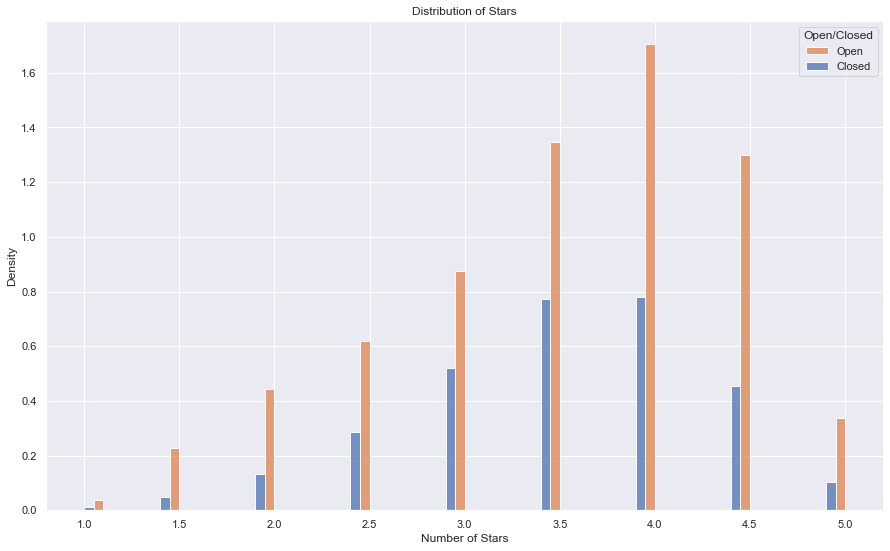

In [10]:
# Configures the plot style
sns.set(style="darkgrid", context="talk", palette="Dark2")
sns.set(rc={"figure.figsize": (15,9)})

# Plots the stars density graph
ax = sns.histplot(data=business, x="stars", hue="is_open", binwidth = 0.1, multiple="dodge", stat="density")
ax.set(xlabel="Number of Stars", ylabel="Density", title="Distribution of Stars")
plt.legend(title="Open/Closed", loc="upper right", labels=["Open", "Closed"])

The open restaurants tend to have higher stars than the closed ones, and notice that the distributions of the stars in both open and closed restaurants are similar. Therefore, *stars* alone might not be a great predictor, and the number of higher stars in the open restaurants are probably due to data skewness toward the open restaurants. Now, let's look at the distribution of the *review_count* by plotting a similar graph.

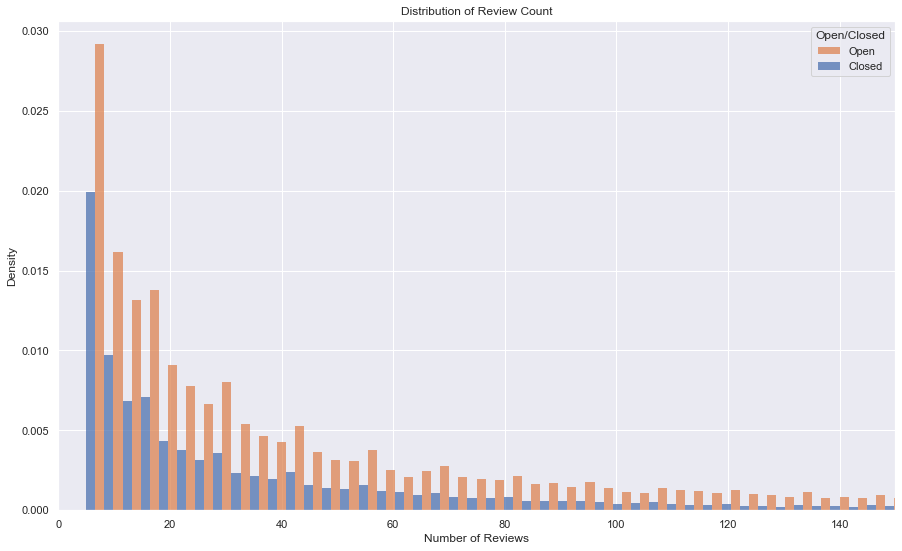

In [11]:
# Plots the review count density graph
ax2 = sns.histplot(data=business, x="review_count", hue="is_open", multiple="dodge", stat="density")

ax2.set_xlim([0,150])
ax2.set(xlabel="Number of Reviews", ylabel="Density", title="Distribution of Review Count")
plt.legend(title='Open/Closed', loc='upper right', labels=['Open', 'Closed'])

Just like the star distribution plot, open restaurants tend to have higher number of reviews, and the distributions look similar. Note that for visualization purpose, we cut off the x-axis at 150, but the summary statistic tells us that on open restaurants have lot more review counts than the closed restaurants.

***
### To be a Chain or Not a Chain?

If a restaurant is part of a chain/franchise, then it will have a higher chance of staying open because restaurant chains have consistency in quality of food, much higher market share, financial back-ups from the parent company, and exposure to the public through numerous advertisements. The customers do not worry about making the "wrong decision" because they already know what to expect, and therefore, they will eat at the chain restaurants even if they have low stars and bad reviews. This feature will be a strong predictor for our restaurant closure model, especially for newly opened businesses that do not have high stars and/or number of reviews. 

Considering the size of our data, same restaurant names could appear by chance. Hence, we will assume that a restaurant belongs to a chain if its business name appears more than three times in the data. For example, all restaurants with the name *Sonic Drive-In* will be counted as a chain. We will take a look at *Sonic* since I like their jalapeno poppers.

In [12]:
# Double checks if Sonic is a fast food chain in our data
sonic = business.loc[business["name"] == 'Sonic Drive-In']
print(f"{sonic.shape[0]} restaurants are part of the Sonic chain business")
sonic.head(5)

113 restaurants are part of the Sonic chain business


,business_id,name,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,TN,37015,36.269593,-87.058943,2.0,6,1,"burgers, fast food, sandwiches, food, ice crea..."
4,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,TN,37207,36.208102,-86.768170,1.5,10,1,"ice cream & frozen yogurt, fast food, burgers,..."
1691,O8RzM_uLVEnDWEhX3whqtQ,Sonic Drive-In,TN,37209,36.108344,-86.923009,1.5,34,1,"food, ice cream & frozen yogurt, burgers, rest..."
2211,8F6OsZYrl3LbR17teMJWJQ,Sonic Drive-In,TN,37209,36.145556,-86.872195,3.0,20,1,"fast food, burgers, hot dogs, food, ice cream ..."
2383,nptxS2jTf6nOQCEcXNL_HA,Sonic Drive-In,ID,83704,43.634449,-116.312838,2.0,18,1,"ice cream & frozen yogurt, restaurants, food, ..."


As expected, Sonic restaurants have relatively low stars and review counts, but most of them are still in business.

Now, we will store the brand (name) of the chain restaurants in a list, and then, we will create a *Chain* column that distinguishes whether a restaurant is part of a chain or not: 1 if restaurant is a chain and 0 if not.

In [13]:
business["name"] = business["name"].str.lower() # Converts all restaurant names to a lower string

# Stores a list of chain restaurants
chains = business['name'].value_counts().loc[lambda x : x > 3]
chains = chains.index
chains_list = list(chains)

In [14]:
# Creates a column that tells us whether a restaurant is part of the chain or not
business["is_chain"] = np.where(business["name"].isin(chains_list), 1, 0)
business.head(5)

,business_id,name,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,is_chain
0,MTSW4McQd7CbVtyjqoe9mw,st honore pastries,PA,19107,39.955505,-75.155564,4.0,80,1,"restaurants, food, bubble tea, coffee & tea, b...",0
1,mWMc6_wTdE0EUBKIGXDVfA,perkiomen valley brewery,PA,18054,40.338183,-75.471659,4.5,13,1,"brewpubs, breweries, food",0
2,CF33F8-E6oudUQ46HnavjQ,sonic drive-in,TN,37015,36.269593,-87.058943,2.0,6,1,"burgers, fast food, sandwiches, food, ice crea...",1
3,k0hlBqXX-Bt0vf1op7Jr1w,tsevi's pub and grill,MO,63123,38.565165,-90.321087,3.0,19,0,"pubs, restaurants, italian, bars, american (tr...",0
4,bBDDEgkFA1Otx9Lfe7BZUQ,sonic drive-in,TN,37207,36.208102,-86.768170,1.5,10,1,"ice cream & frozen yogurt, fast food, burgers,...",1


Notice that *Sonic Drive-In* is marked as a chain in the data. Let's see how being part of a chain affects the restaurant's closure.

In [15]:
# Shows how many chain restaurants are open/closed
chain_open = business.loc[(business["is_open"] == 1) & (business["is_chain"] == 1)]
chain_closed = business.loc[(business["is_open"] == 0) & (business["is_chain"] == 1)]

# Shows how many non-chain/non-franchise restaurants are open/closed
nonchain_open = business.loc[(business["is_open"] == 1) & (business["is_chain"] == 0)]
nonchain_closed = business.loc[(business["is_open"] == 0) & (business["is_chain"] == 0)]

print(f"For all chain restaurants, {len(chain_open):,} are open and {len(chain_closed):,} are closed\nFor all non-chain restaurants, {len(nonchain_open):,} are open and {len(nonchain_closed):,} are closed")

For all chain restaurants, 14,432 are open and 2,929 are closed
For all non-chain restaurants, 29,482 are open and 16,914 are closed


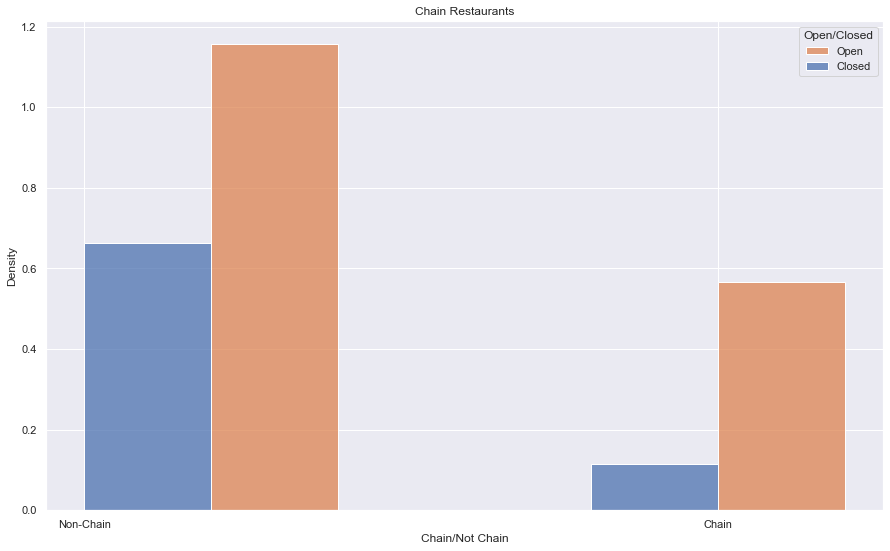

In [16]:
# Plots the comparison of chain/non-chain restaurant closure
ax3 = sns.histplot(data=business, x="is_chain", hue="is_open", multiple="dodge", stat="density", binwidth=0.4)
plt.xticks(np.arange(2), ("Non-Chain", "Chain"))

ax3.set(xlabel="Chain/Not Chain", ylabel="Density", title="Chain Restaurants")
plt.legend(title='Open/Closed', loc='upper right', labels=['Open', 'Closed'])

We can see that about one-sixth of the chain restaurants are closed while about one-third of the non-chain restaurants are closed, and thus, non-chain restaurants are at a higher risk of closing.

***
### Local Density and Competition

In this section, we will analyze how a large cluster of restaurants affects the likelihood of closure. If a restaurant is located in a dense area with bunch of other restaurants, then it could lose customers to better surrounding restaurants or could benefit from having more customers visiting the area to try out new foods. Moreover, if the restaurant is located out of nowhere, then it is much more difficult for the customers to get to the place.

Our data contains restaurants from multiple states, and because restaurants in California will not be influenced by those in Florida, our analysis should be done state by state. We will start with business locations in Florida since it has considerable amount of data.

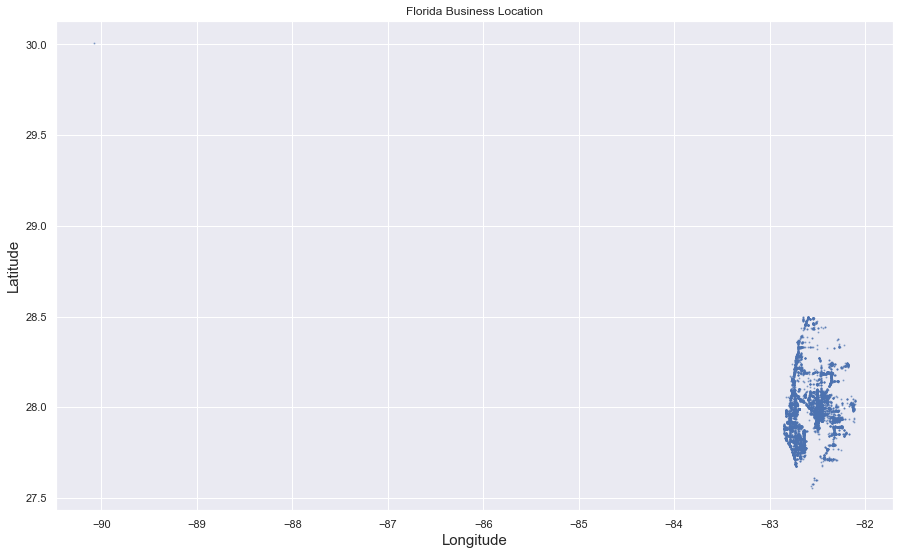

In [17]:
florida = business.loc[business["state"] == "FL"]

# Creates a scatter plot based on latitude & longitude
plt.scatter(x=florida["longitude"], y=florida["latitude"], s=1, alpha=0.5)
plt.title("Florida Business Location")
plt.xlabel("Longitude", size=15)
plt.ylabel("Latitude", size=15)
plt.show()

Based on our scatter plot, we can observe that there is a restaurant that is away from all the others.

In [18]:
outlier = florida.loc[florida["latitude"] > 30] # Shows the outlier restaurant far away from the others
outlier

,business_id,name,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,is_chain
35385,TOFm4N1vBcqpZ-rywMMeJg,adrians bakery,FL,70122,30.006262,-90.074708,2.5,31,1,"bakeries, ice cream & frozen yogurt, food, des...",0


Since this is just one single location, we will remove this point from our plot, and focus on the main region of our map.

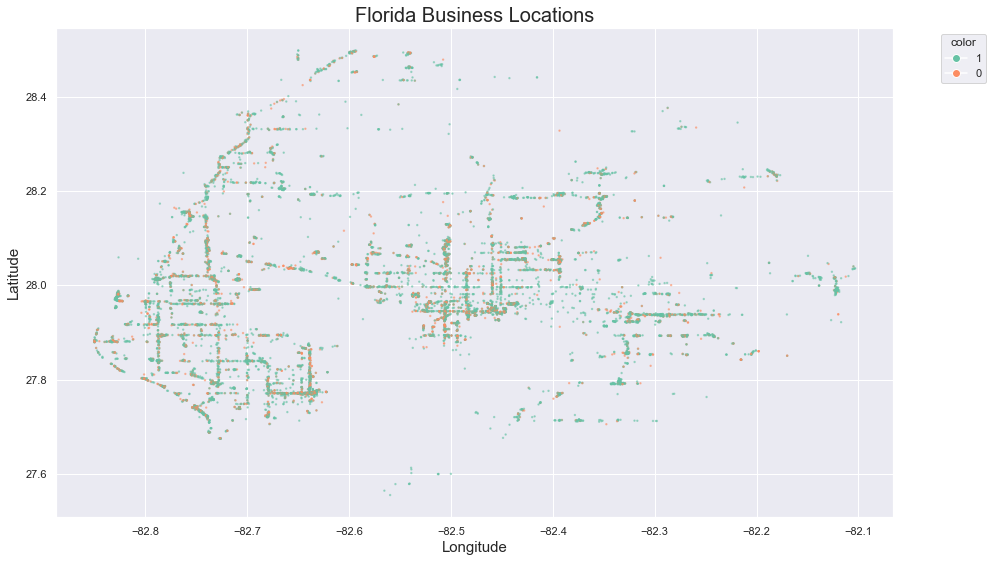

In [19]:
florida = florida.loc[florida["latitude"] < 30] # Removes the outlier

# Configures the scatter plot. Restaurants colored green as open (1) & orange as closed (0) 
color_labels = florida['is_open'].unique()
rgb_values = sns.color_palette("Set2", 4)
color_map = dict(zip(color_labels, rgb_values))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in color_map.items()]

plt.scatter(x=florida["longitude"], y=florida["latitude"], s=2, alpha=0.5, c=florida["is_open"].map(color_map))

plt.title("Florida Business Locations", size=20)
plt.xlabel("Longitude", size=15)
plt.ylabel("Latitude", size=15)
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The plot is bit small, but you can see some orange dots among the clustered area, primarily in a vertical strip, which could be a long street with many restaurants. 

We will use the Gaussian Mixture Model (GMM) to create the clusters of restaurants in Florida. GMM is more flexible with cluster variance and covariances, which are very advantageous over K-means clustering algorithm since it is likely that the clusters are dense and spread out (more variance) due to the geographic feature of the restaurant businesses.

Let's train the GMM with the latitude and longitude and plot the clusters. Based on the Florida map, we will have several clusters, and for now, we will set the *n_compoments* parameter to 4. In addition, since GMM can converge on locally optimal points, we will set the *n_init* parameter to 5. This will randomly initialize and train 5 GMMs and, we will take the best model.

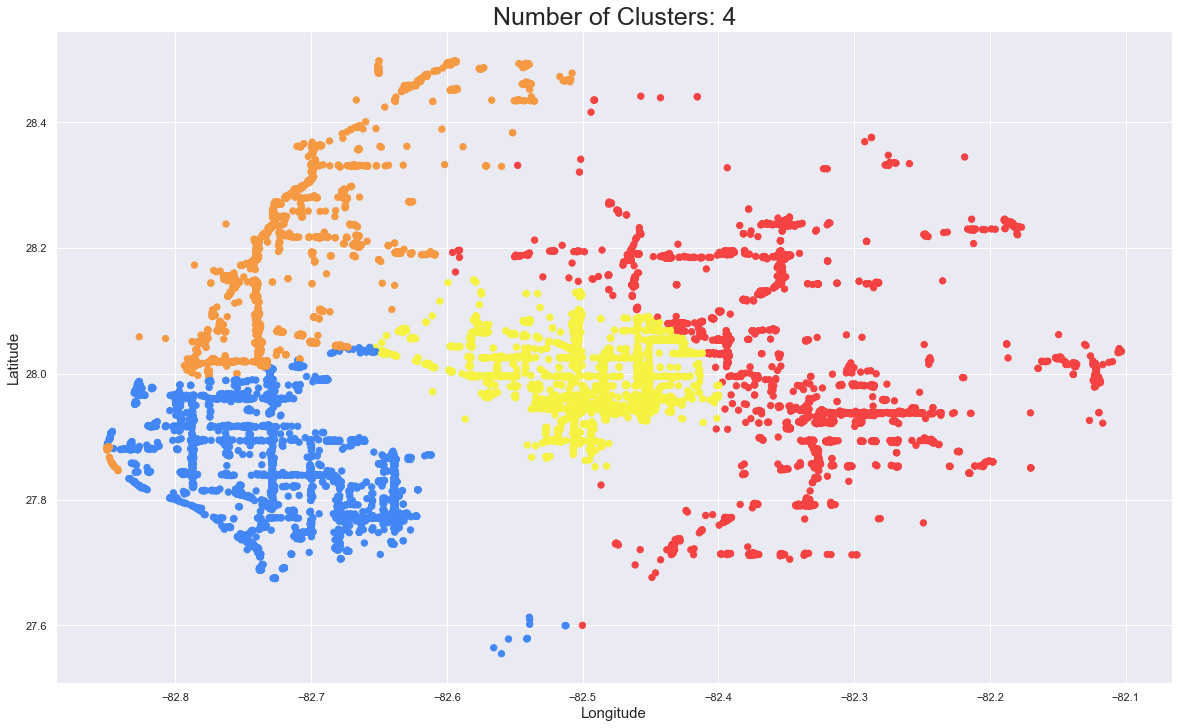

In [20]:
# Trains GMM and plot the clusters
def plot_clusters(n):
    """
    Parameters
    ----------
    n : Number of clusters
    """
    
    #Fit gmm and get labels
    X = florida[['longitude','latitude']].values
    gmm = GaussianMixture(n_components=n, random_state=11, n_init=5)
    labels = gmm.fit(X).predict(X)
    
    #Assign a color to each label
    color = ['#f54242','#4287f5','#f59942','#f5f242','#69f542','#b342f5']
    c = [color[l] for l in labels]
    
    #Scatter plot
    plt.figure(figsize=(20, 12))
    plt.scatter(x=X[:, 0], y=X[:, 1], c=c, s=40, cmap='Set1', zorder=1)
    plt.title('Number of Clusters: {}'.format(n),size=25)
    plt.xlabel('Longitude',size=15)
    plt.ylabel('Latitude',size=15)
    
plot_clusters(4)

We could increase the number of clusters, but we also want to avoid overfitting. Based on the plot, around four to six clusters look more reasonable. We can calculate the *silhouette score* to see if a data point is very compact within the cluster to which it belongs and if it is far away from the other clusters.

In general, the *silhouette score* considers:

    1. The mean distance between a sample and all other points in the same cluster.
    2. The mean distance between a sample and all other points in the next nearest cluster

which is then defined as:

$$-1\le \frac{b-a}{max(a,b)} \le 1$$ 

Where **a** is the mean intra-cluster distance and **b** is the distance between a sample and the nearest cluster that the sample is not part of.  

In [21]:
X = florida[['longitude','latitude']].values

n_clusters = np.arange(2, 10) # Consider up to 10 clusters
iterations = 20 # Iterating 20 times for any randomness
silhouette_score = {}

for n in n_clusters:
    scores_lst = []
    for _ in range(iterations):
        gmm = GaussianMixture(n, random_state=11, n_init=5).fit(X) 
        labels = gmm.predict(X)
        score = metrics.silhouette_score(X, labels, metric='euclidean')
        scores_lst.append(score)
    mean_score = np.mean(scores_lst)
    silhouette_score[n] = mean_score

n = max(silhouette_score, key=lambda k: silhouette_score[k])
print(f"We should use {n} for the n_compoments parameter in our model")

We should use 6 for the n_compoments parameter in our model


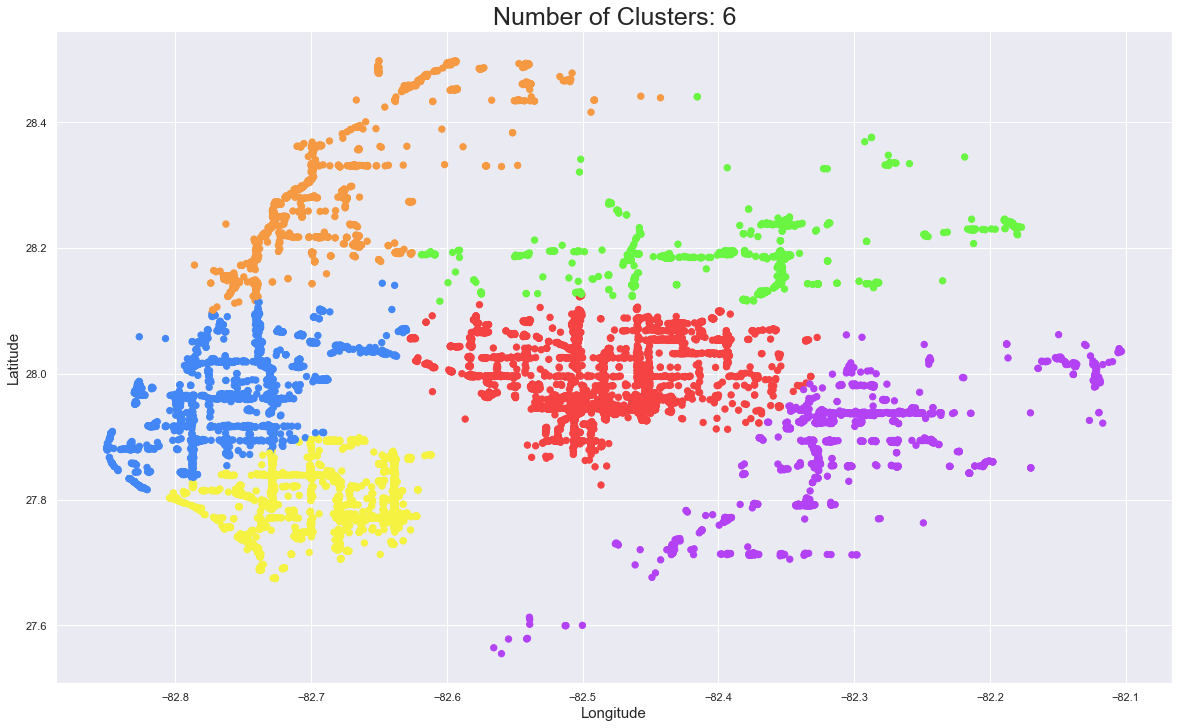

In [22]:
plot_clusters(n)

In [23]:
gmm = GaussianMixture(n_components=n, random_state=11, n_init=5)
labels = gmm.fit(X).predict(X)

florida["cluster"] = labels
florida.head(5)

,business_id,name,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,is_chain,cluster
5,eEOYSgkmpB90uNA7lDOMRA,vietnamese food truck,FL,33602,27.955269,-82.456320,4.0,10,1,"vietnamese, food, restaurants, food trucks",0,0
7,0bPLkL0QhhPO5kt1_EXmNQ,zio's italian market,FL,33771,27.916116,-82.760461,4.5,100,0,"food, delis, italian, bakeries, restaurants",0,1
24,0qNpTGTcqPwOLi2hADx4Xw,charlie's market,FL,33610,28.010360,-82.430042,3.0,9,1,"food, grocery, convenience stores",0,0
26,uI9XODGY_2_ieTE6xJ0myw,roman forum,FL,33618,28.046203,-82.505053,4.0,23,0,"restaurants, american (new), italian",0,0
27,JgpnXv_0XhV3SfbfB50nxw,joe's pizza,FL,33607,27.960514,-82.506127,4.0,35,0,"restaurants, pizza",1,0


From the plot, we can see that blue, yellow and red clusters are more compact than the other clusters. With these, we will now calculate the relative average of the *review_count* feature, which compares the number of reviews a restaurant in the cluster with the average review of the restaurants in the cluster. 

This way, we could observe if the restaurant is receiving more/less reviews (which is equivalent to having more/fewer customers) from its local "competitions."

In [24]:
data_point = florida["review_count"].values[0] # First restaurant of the Florida data
cluster_index = labels[0] # Cluster label of the data point

# Calculates the relative average of the data point in the cluster
cluster_data = florida["review_count"].values[labels == cluster_index]
mean = np.mean(cluster_data, axis=0)
standard_dev = np.std(cluster_data, axis=0)
relative_average = (data_point - mean) / standard_dev

print(relative_average)

-0.43115123438604036


Looks like this restaurant receives lower reviews compare to the average reviews of the restaurants in the cluster. Do not forget that this was only confined to Florida. We will now apply this approach to all the restaurants in the data, state by state.

In [25]:
all_states = business["state"].unique()
state_by_state = []

for state in all_states:
    # Filters the data by a specific state
    state_data = business.loc[business["state"] == state]
    X = state_data[["longitude","latitude"]].values 
    
    # Calculates the silhouette score for our n_components
    n_clusters = np.arange(2, 10)
    iterations = 20
    silhouette_score = {}
    
    for n in n_clusters:
        scores = []
        for _ in range(iterations):
            gmm = GaussianMixture(n_components=n, random_state=11, n_init=5).fit(X) 
            labels = gmm.predict(X)
            score = metrics.silhouette_score(X, labels, metric='euclidean')
            scores.append(score)
        mean_score = np.mean(scores)
        silhouette_score[n] = mean_score

    n = max(silhouette_score, key=lambda k: silhouette_score[k]) # Our "best" n_component for the model
    
    # Assigns a cluster to the data point
    gmm = GaussianMixture(n_components=n, random_state=11, n_init=5)
    labels = gmm.fit(X).predict(X)
    
    data = state_data.copy()
    data.loc[:, "cluster"] = labels
    
    # Calculates the relative average
    state_grouped = data.groupby("cluster")
    mean = state_grouped.mean()["review_count"]
    standard_dev = state_grouped.std()["review_count"]
    
    # Creates a column for relative average
    data.loc[:, "relative_review"] = (data["review_count"] - data["cluster"].map(mean)) / data["cluster"].map(standard_dev)
    data.drop(columns=["cluster"], inplace=True)
    
    # Store the state filtered dataframe in a list for concatenation
    state_by_state.append(data)

In [26]:
business = pd.concat(state_by_state, axis=0)
business.head(5)

,business_id,name,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,is_chain,relative_review
0,MTSW4McQd7CbVtyjqoe9mw,st honore pastries,PA,19107,39.955505,-75.155564,4.0,80,1,"restaurants, food, bubble tea, coffee & tea, b...",0,-0.182051
1,mWMc6_wTdE0EUBKIGXDVfA,perkiomen valley brewery,PA,18054,40.338183,-75.471659,4.5,13,1,"brewpubs, breweries, food",0,-0.556913
8,MUTTqe8uqyMdBl186RmNeA,tuna bar,PA,19106,39.953949,-75.143226,4.0,245,1,"sushi bars, restaurants, japanese",0,0.444344
9,ROeacJQwBeh05Rqg7F6TCg,bap,PA,19147,39.943223,-75.162568,4.5,205,1,"korean, restaurants",0,0.292491
14,QdN72BWoyFypdGJhhI5r7g,bar one,PA,19147,39.939825,-75.157447,4.0,65,0,"cocktail bars, bars, italian, nightlife, resta...",0,-0.238996


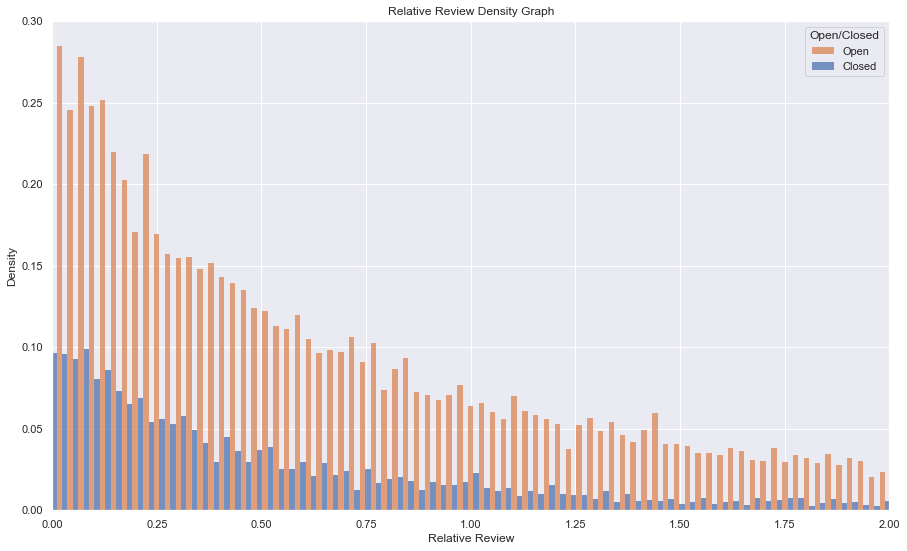

In [27]:
# Plots the relative review density graph
ax4 = sns.histplot(data=business, x="relative_review", hue="is_open", multiple="dodge", stat="density")

ax4.set_xlim([0,2])
ax4.set_ylim([0,0.3])
ax4.set(xlabel="Relative Review", ylabel="Density", title="Relative Review Density Graph")
plt.legend(title='Open/Closed', loc='upper right', labels=['Open', 'Closed'])

The distribution looks similar but open restaurants tend to have higher relative review (towards the right tail of the graph).

***
## User Review Data

We will now explore the user review data. Because of the massive JSON file size, we will use the *chunksize* parameter to reduce memory usage and computation time.

In [28]:
chunk_file = pd.read_json("data\yelp_academic_dataset_review.json", chunksize=10000, lines=True) # Chunksize can be smaller
user_reviews = pd.concat([chunk for chunk in chunk_file]) # Combines the partitioned data

In [29]:
user_reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

There are some columns that might not be helpful for the prediction. For example, *useful*, *funny*, and *cool* columns could add more weight to the review's validity, but for now, we will drop these columns.

In [30]:
# Drops unnecessary columns in our review data
drop_cols = ["review_id", "user_id", "useful", "funny", "cool"]
user_reviews.drop(drop_cols, axis=1, inplace=True)

In [31]:
user_reviews.head(3)

,business_id,stars,text,date
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30


Having reviews alone is not meaningful so we will merge the business data with the review data to see which restaurant has good/bad reviews.

In [32]:
drop_cols = ["state", "postal_code", "latitude", "longitude"]

business_copy = business.copy() # Creates copy of our dataframe
business_copy.drop(drop_cols, axis=1, inplace=True)

user_reviews_copy = user_reviews.copy()

# Sets the index as business_id, which is unique for every businesses
business_copy.set_index("business_id", inplace=True)
user_reviews_copy.set_index("business_id", inplace=True)

# Joins data and modifies column names to differentiate overall stars & stars given by the reviewer
business_and_reviews = business_copy.join(user_reviews_copy, lsuffix="_business", rsuffix="_review")

In [33]:
business_and_reviews.head(5)

,name,stars_business,review_count,is_open,categories,is_chain,relative_review,stars_review,text,date
business_id,,,,,,,,,,
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,4,Ate here for the 1st time on Saturday 08/07/20...,2020-08-09 19:19:16
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,5,Absolutely fantastic!!!! I'll be back for sur...,2020-09-05 20:09:03
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,3,I was sadly disappointed in my experience. We ...,2020-06-13 22:03:50
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,5,Great new local seafood spot. It' actually rea...,2020-02-11 00:30:51
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,3,This is a food truck alongside a picnic area. ...,2021-03-06 01:39:34


In [34]:
print(f"business data has {business_copy.shape[0]:,} rows, user review data has {user_reviews.shape[0]:,} rows, and combined data has {business_and_reviews.shape[0]:,} rows")

business data has 63,757 rows, user review data has 6,990,280 rows, and combined data has 5,143,948 rows


The merged data is missing about 1.8 million rows of the user review data. Some of the *business_id* could have been excluded in the business data because of the restaurant closure or the limitation of the Yelp's academic dataset. In addition, there could be timing difference in obtaining the two separate dataset: maybe the business dataset is based on 2021 but the review dataset is based on 2019.

In [35]:
# Checks the missing data
review_index = user_reviews_copy.index
business_index = business_copy.index

missing = user_reviews_copy[~review_index.isin(business_index)]
print(f"The missing data has {missing.shape[0]:,} rows")

The missing data has 1,846,332 rows


We can conclude that the review dataset contained *business_ids* that no longer exist in the business dataset.

***
### Reviewers Sentiment Score

The *stars* and *review counts* could be good predictors of the model. However, the stars alone will not offer enough information for the consumers. After all, the average star of the restaurant only shows the overall rating as a business, and does not tell us about the quality of the food, service, cleaniness, pricing, and other important aspects of restaurant in detail. Moreover, we observed that the distribution of the star rating between open and close restaurants is similar, and it could only measure the customer's general feeling with the whole dining experience, without any further details. 

As a result, many consumer tend to rely on the review comments written by the other Yelp users. Positive comments about food, services, ambience, and etc. often provide a nice "guarantee" to the deciding customer, attracting more customers to the restaurant, and thereby decreasing the chance of closing the business. On contrary, negative comments will shun away the potential customers, and will pose a high risk of closure with a revenue loss.

We will now look at some of the review comments on Frankie's Raw Bar in Florida.

In [36]:
frankies_reviews = business_and_reviews.loc[business_and_reviews["name"] == "frankie's raw bar"]
frankies_reviews.head(5)

,name,stars_business,review_count,is_open,categories,is_chain,relative_review,stars_review,text,date
business_id,,,,,,,,,,
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,4,Ate here for the 1st time on Saturday 08/07/20...,2020-08-09 19:19:16
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,5,Absolutely fantastic!!!! I'll be back for sur...,2020-09-05 20:09:03
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,3,I was sadly disappointed in my experience. We ...,2020-06-13 22:03:50
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,5,Great new local seafood spot. It' actually rea...,2020-02-11 00:30:51
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,3,This is a food truck alongside a picnic area. ...,2021-03-06 01:39:34


It seems like Frankie's have pretty high stars rating. We will pick one review with 5 stars, one with 3, and another with 1.

In [37]:
frankies_reviews["text"][1]

"Absolutely fantastic!!!!  I'll be back for sure. Fried lobster tail was delicious. Five star for sure."

Clearly, the reviewer loved the food based on the four exclamations after fantastic, and the fact that the lobster was delicious.

In [38]:
frankies_reviews.loc[frankies_reviews["stars_review"] == 3]["text"][0]

"I was sadly disappointed in my experience. We ordered crabs and they were extremely small, watery and over half were bad(sick crabs), we ordered beans and rice which lacked flavor and literally had one bean in it that you can see from the picture. The coleslaw also lacked taste. We ask for grouper nuggets and a few were not cooked all the way. So given the food experience it was nothing like the reviews we read. Why I am giving them three stars is because the waitress that waited on us (young pregnant girl) was EXTREMELY polite and an excellent server. The owner came by our table and greeted us which is something not done often these days. They also took half off the crabs since half were bad trying to make it right but in the end we paid over $50 (including tip) for food that we barley ate and had to go to McDonald's after. \nI did see other food that may have been better choices but we came for the crab."

Seems like this person did not have a fantastic time unlike the previous reviewer. The food, especially the crab, was not that great, but the restaurant did have friendly and good service.

In [39]:
frankies_reviews.loc[frankies_reviews["stars_review"] == 1]["text"][0]

"Be careful before ordering the coleslaw, I found a rusted push pin in mine. When I showed it to the waitress she apologized and said it came from the board above where food is prepared. Just thankful that I did not eat the pin, can't image the internal damage it could have done.  I was offered a free desert but passed on that. Don't know if I would go back."

This reviewer clearly had a terrible experience by finding a rusted push pin the coleslaw.

We will measure how positive/negative review comments is related to the business closure rate by utilizing the VADER sentiment analysis tool, which determines whether the comment has positive, negative, or netural connotation. VADER is a lexicon and a rule-based sentiment analysis tool specifically attuned to sentiments expressed in social media. In addition, it keeps the model simple since it only requires minimal pre-work, and it does not use any machine learning to figure out the text sentiment.

Note that we will only look at the compound score, which "sums the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive)."

We will take a look at the sentiment score of the sample reviews in Frankie's Raw Bar.

In [40]:
# Initialzing VADER
sentimentAnalyser = SentimentIntensityAnalyzer()

In [41]:
sentimentAnalyser.polarity_scores(frankies_reviews["text"][1])

{'neg': 0.0, 'neu': 0.473, 'pos': 0.527, 'compound': 0.924}

In [42]:
sentimentAnalyser.polarity_scores(frankies_reviews.loc[frankies_reviews["stars_review"] == 3]["text"][0])

{'neg': 0.042, 'neu': 0.906, 'pos': 0.052, 'compound': 0.4009}

In [43]:
sentimentAnalyser.polarity_scores(frankies_reviews.loc[frankies_reviews["stars_review"] == 1]["text"][0])

{'neg': 0.028, 'neu': 0.853, 'pos': 0.119, 'compound': 0.5859}

By looking at the compound score of each review comments, we can see that the 1 star review has slightly more positive connotation than the 3 star one, and as we expected, the 5 star one has a very positive connotation. It seems that the third review is slightly neutral even though the customer rated the lowest. Let's pick a review that has a 1 star rating and has lot more negative words.

In [44]:
low_rating = business_and_reviews[business_and_reviews["stars_review"] == 1]
low_rating.head(5)

,name,stars_business,review_count,is_open,categories,is_chain,relative_review,stars_review,text,date
business_id,,,,,,,,,,
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,1,"Be careful before ordering the coleslaw, I fou...",2021-04-12 19:46:10
--0iUa4sNDFiZFrAdIWhZQ,pupuseria y restaurant melba,3.0,14,1,"food, restaurants, specialty food, mexican, et...",0,-0.462739,1,Didn't even get to try the papusas. Went in an...,2017-02-12 18:34:45
--0iUa4sNDFiZFrAdIWhZQ,pupuseria y restaurant melba,3.0,14,1,"food, restaurants, specialty food, mexican, et...",0,-0.462739,1,"If I could give 0 stars, I would. Ordered some...",2016-09-21 18:37:44
--0iUa4sNDFiZFrAdIWhZQ,pupuseria y restaurant melba,3.0,14,1,"food, restaurants, specialty food, mexican, et...",0,-0.462739,1,"Dirty, trash all over ,rude clientele ,do not ...",2010-10-02 02:52:23
--8IbOsAAxjKRoYsBFL-PA,the original italian pie,3.0,27,0,"food, restaurants, italian",1,-0.300230,1,"Took me for 40 bucks through grubhub, no call ...",2018-06-19 10:46:45


In [45]:
low_rating["text"][3]

'Dirty, trash all over ,rude clientele ,do not speak english a scar in Clementon.'

This review comment definitely has lot more negative words than the one in Frankie's Raw Bar.

In [46]:
sentimentAnalyser.polarity_scores(low_rating["text"][3])

{'neg': 0.33, 'neu': 0.67, 'pos': 0.0, 'compound': -0.7096}

As expected, we get a negative compound score, confirming that the reviewer did not like the experience.

Now, we will calculate a compound score for each comment, and compute an average sentiment score for each restaurants.

In [47]:
sentiment_review = business_and_reviews.copy()

# Creates a column that has compound polarity score from VADER analysis
sentiment_review["polarity_score"] = sentiment_review['text'].apply(lambda x: sentimentAnalyser.polarity_scores(x)["compound"])
sentiment_review.head(5)

,name,stars_business,review_count,is_open,categories,is_chain,relative_review,stars_review,text,date,polarity_score
business_id,,,,,,,,,,,
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,4,Ate here for the 1st time on Saturday 08/07/20...,2020-08-09 19:19:16,0.6124
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,5,Absolutely fantastic!!!! I'll be back for sur...,2020-09-05 20:09:03,0.9240
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,3,I was sadly disappointed in my experience. We ...,2020-06-13 22:03:50,0.4009
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,5,Great new local seafood spot. It' actually rea...,2020-02-11 00:30:51,0.9059
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,3,This is a food truck alongside a picnic area. ...,2021-03-06 01:39:34,0.7088


Now that we have a polarity score for each Yelp reviews, we will calculate an average sentiment score for each restaurants.

In [48]:
average_sentiment = sentiment_review.copy() # Creates a copy of the dataframe

# Calculates the average polarity score per unique restaurants
average_sentiment = average_sentiment.groupby("business_id").agg({"name": "first", "stars_business": "first",
                                                                  "review_count": "first", "is_open": "first",
                                                                  "categories": "first", "is_chain": "first",
                                                                  "relative_review": "first", "polarity_score": np.mean})
average_sentiment.head(5)

,name,stars_business,review_count,is_open,categories,is_chain,relative_review,polarity_score
business_id,,,,,,,,
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,0.851179
--0iUa4sNDFiZFrAdIWhZQ,pupuseria y restaurant melba,3.0,14,1,"food, restaurants, specialty food, mexican, et...",0,-0.462739,0.544421
--8IbOsAAxjKRoYsBFL-PA,the original italian pie,3.0,27,0,"food, restaurants, italian",1,-0.300230,0.261070
--ARBQr1WMsTWiwOKOj-FQ,traveling corks,4.5,23,0,"wine bars, nightlife, bars",0,-0.355721,0.920148
--MbOh2O1pATkXa7xbU6LA,sweet lizard,4.0,25,0,"food, ice cream & frozen yogurt",0,-0.472317,0.844852


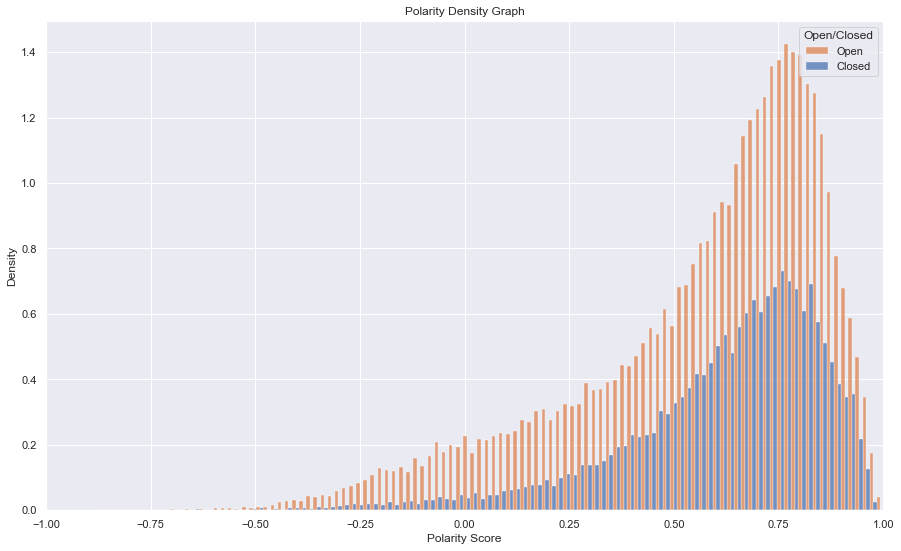

In [49]:
# Plots polarity score density graph
ax5 = sns.histplot(data=average_sentiment, x="polarity_score", hue="is_open", multiple="dodge", stat="density")

ax5.set_xlim([-1,1])
ax5.set(xlabel="Polarity Score", ylabel="Density", title="Polarity Density Graph")
plt.legend(title='Open/Closed', loc='upper right', labels=['Open', 'Closed'])

Similar to other features that we have, the distribution looks similar for both closed and open restaurants with more positive score at the right tail of the distribution.

***
### Yelp Age

Age of the restaurant is another feature that we could leverage. If the business has been open for a long time (say 10+ years), then we could safely assume that it is likely to stay open because the restaurant is already well established and the quality of the food & service has been verified by many customers. On contrary, newer restaurants will need to make its way up by providing consistently good food & services.

We will estimate this feature by taking the difference between the date of the newest and the oldest review. Keep in mind that we will not be comparing the review date with the today's date because of the timing issue with the dataset (we cannot assure if the open restaurant is still open). Furthermore, the actual age of the business could be very off from our Yelp age since some of the oldest restaurants might not have been listed on Yelp until recently.

In [50]:
age_data = business_and_reviews.copy()

# Converts our date column into a yyyy-mm-dd format
age_data["date"] = pd.to_datetime(age_data['date']).dt.date
age_data = age_data.groupby(["business_id", "name"])["date"].agg(["min", "max"])
age_data.head(5)

,,min,max
business_id,name,,
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,2020-01-29,2022-01-19
--0iUa4sNDFiZFrAdIWhZQ,pupuseria y restaurant melba,2009-04-14,2021-06-21
--8IbOsAAxjKRoYsBFL-PA,the original italian pie,2015-06-16,2019-02-27
--ARBQr1WMsTWiwOKOj-FQ,traveling corks,2015-01-04,2018-03-04
--MbOh2O1pATkXa7xbU6LA,sweet lizard,2013-04-14,2017-11-12


In [51]:
# Calculates the yelp age in years
age_data["yelp_age"] = (age_data["max"] - age_data["min"])
age_data["yelp_age"] = age_data["yelp_age"].dt.days
age_data["yelp_age"] = (age_data["yelp_age"].astype(int)) / 365 # Scaled to years

age_data.drop(columns=["min", "max"], inplace=True)

In [52]:
yelp_age = pd.merge(average_sentiment, age_data, on="business_id", how="inner") # Uses merge instead of join this time
yelp_age.head(5)

,name,stars_business,review_count,is_open,categories,is_chain,relative_review,polarity_score,yelp_age
business_id,,,,,,,,,
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,0.851179,1.975342
--0iUa4sNDFiZFrAdIWhZQ,pupuseria y restaurant melba,3.0,14,1,"food, restaurants, specialty food, mexican, et...",0,-0.462739,0.544421,12.194521
--8IbOsAAxjKRoYsBFL-PA,the original italian pie,3.0,27,0,"food, restaurants, italian",1,-0.300230,0.261070,3.704110
--ARBQr1WMsTWiwOKOj-FQ,traveling corks,4.5,23,0,"wine bars, nightlife, bars",0,-0.355721,0.920148,3.164384
--MbOh2O1pATkXa7xbU6LA,sweet lizard,4.0,25,0,"food, ice cream & frozen yogurt",0,-0.472317,0.844852,4.583562


Let's explore the *yelp_age* column by plotting a density graph with open and closed restaurants.

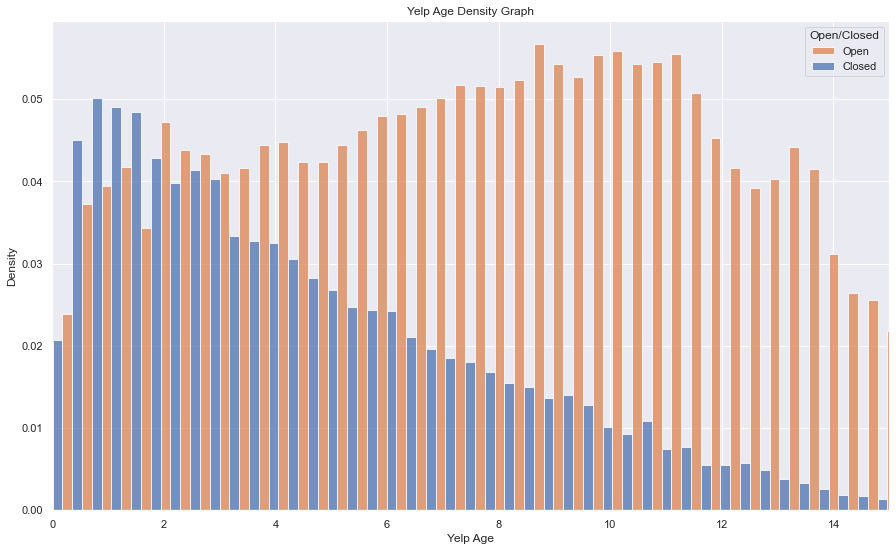

In [53]:
# Plots the Yelp age density graph
ax6 = sns.histplot(data=yelp_age, x="yelp_age", hue="is_open", multiple="dodge", stat="density")

ax6.set_xlim([0,15])
ax6.set(xlabel="Yelp Age", ylabel="Density", title="Yelp Age Density Graph")
plt.legend(title='Open/Closed', loc='upper right', labels=['Open', 'Closed'])

The distribution looks asymmetrical, and closed restaurants are skewed to the left tail. As we hypothesized in the beginning of this section, we can observe that currently open restaurants have been operating for a long time, and we can reasonably assume that these restaurants will continue to stay open. Hence, we could suggest that the longer the restaurant has been open, the chance of staying open (thereby, not defaulting) is higher than the newer restaurants.

***
### Recent / Latest Reviews

More review counts will help the restaurants to stay in business because even though it could have a low star rating (say 3), there must be a reason why such a "lowly-rated" restaurant attracts so many customers. 

Building on this idea, we could hypothesize that the number of latest/recent reviews written on Yelp could be a good feature for the model. If the restaurant does not receive reviews for few months, then it is likely that the business is not attracting new customers for more revenue. On contrary, if the restaurant receives Yelp reviews on a daily basis, then it is consistently having new customers. We will start by looking at one of each open/closed restaurant, and for equal comparison, we will choose the restaurants that have similar stars rating and number of reviews.

In [54]:
latest_reviews = business_and_reviews.copy()
latest_reviews["date"] = pd.to_datetime(latest_reviews['date']).dt.date

many_reviews = business.loc[business['review_count'] > 500] # Pick restaurant with more than 500 reviews

In [55]:
restaurants_open = many_reviews.loc[(many_reviews["is_open"] == 1)]
restaurants_open.head(1)

,business_id,name,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,is_chain,relative_review
167,dChRGpit9fM_kZK5pafNyA,the love,PA,19103,39.950656,-75.170899,4.0,618,1,"restaurants, american (new), breakfast & brunc...",0,1.860375


In [56]:
restaurants_closed = many_reviews.loc[(many_reviews["is_open"] == 0)]
restaurants_closed.head(1)

,business_id,name,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,is_chain,relative_review
1664,mUIBtlWNPD7sz3rGGWQ1RA,kanella,PA,19107,39.946332,-75.157948,4.5,579,0,"mediterranean, food, greek, restaurants, break...",0,1.712318


In [57]:
love = latest_reviews.loc[latest_reviews["name"] == "the love"]
kanella = latest_reviews.loc[latest_reviews["name"] == "kanella"]

Text(0.5, 1.0, "Open Restaurant's Reviews over time")

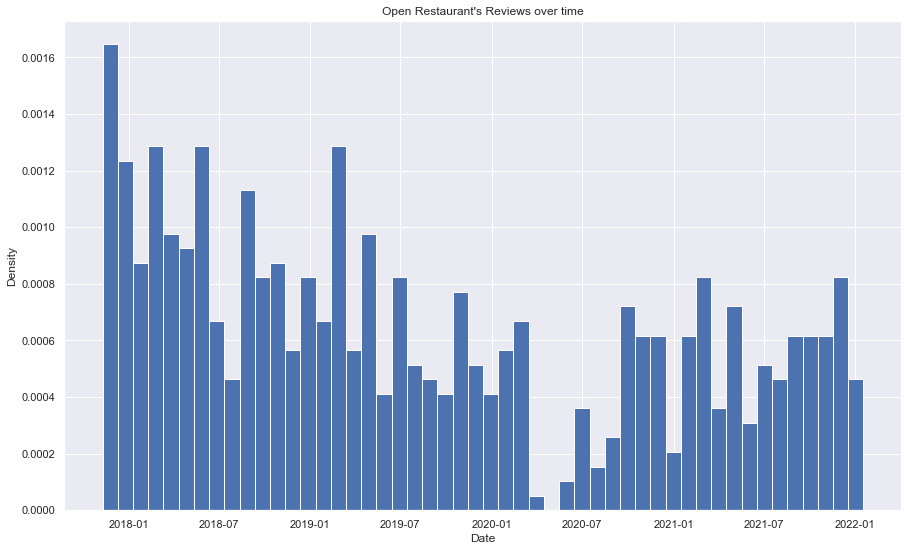

In [58]:
# Open restaurant
love["date"].hist(density=1, bins=50) 
plt.ylabel("Density") 
plt.xlabel("Date") 
plt.title("Open Restaurant's Reviews over time")

From this density plot, we can see consistent amount of reviews throughout the years. we can assume the sudden drop in 2020 is from COVID-19.

Text(0.5, 1.0, "Closed Restaurant's Reviews over time")

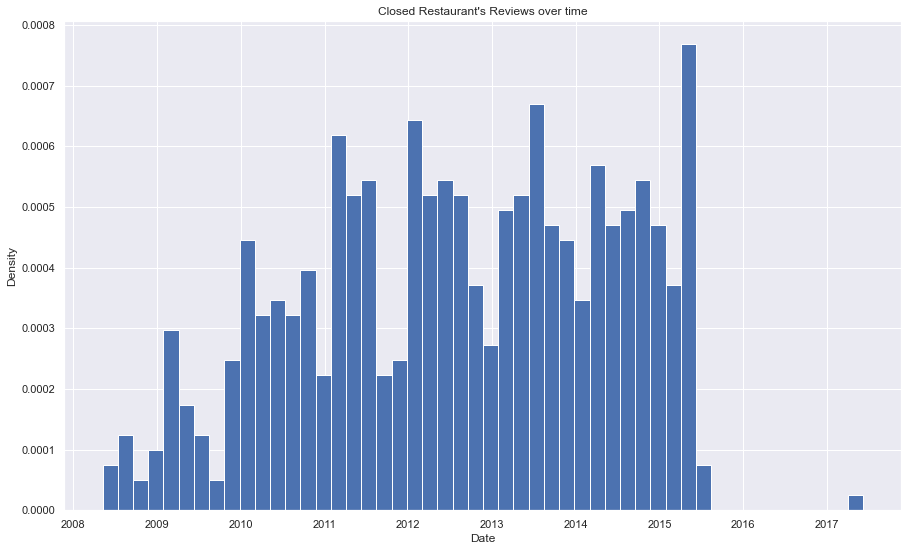

In [59]:
# Closed restaurant
kanella["date"].hist(density=1, bins=50) 
plt.ylabel("Density") 
plt.xlabel("Date") 
plt.title("Closed Restaurant's Reviews over time")

Compared to the above plot, we can see a sudden drop of number of reviews at the end. Now, we will compute the number of recent reviews per restaurant. Since each restaurant has different review date, we will normalize the *date* column with a time interval $t \in [0,1]$ from the oldest review to the most recent review. In addition, we will only count the reviews where $t \geq 0.9$ to measure how much recent reviews were written for the restaurant.

In [60]:
latest_reviews["recent_review"] = latest_reviews.groupby("business_id")["date"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
latest_reviews.head(5)

,name,stars_business,review_count,is_open,categories,is_chain,relative_review,stars_review,text,date,recent_review
business_id,,,,,,,,,,,
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,4,Ate here for the 1st time on Saturday 08/07/20...,2020-08-09,0.267684
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,5,Absolutely fantastic!!!! I'll be back for sur...,2020-09-05,0.305132
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,3,I was sadly disappointed in my experience. We ...,2020-06-13,0.188627
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,5,Great new local seafood spot. It' actually rea...,2020-02-11,0.018031
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,3,This is a food truck alongside a picnic area. ...,2021-03-06,0.557559


In [61]:
count_recents = latest_reviews.loc[latest_reviews["recent_review"] >= 0.9].groupby("business_id").count()["recent_review"]
recent_reviews = yelp_age.copy()
recent_reviews["recent_reviews"] = count_recents
recent_reviews.head(5)

,name,stars_business,review_count,is_open,categories,is_chain,relative_review,polarity_score,yelp_age,recent_reviews
business_id,,,,,,,,,,
---kPU91CF4Lq2-WlRu9Lw,frankie's raw bar,4.5,24,1,"seafood, restaurants, latin american, food, fo...",0,-0.252754,0.851179,1.975342,7
--0iUa4sNDFiZFrAdIWhZQ,pupuseria y restaurant melba,3.0,14,1,"food, restaurants, specialty food, mexican, et...",0,-0.462739,0.544421,12.194521,1
--8IbOsAAxjKRoYsBFL-PA,the original italian pie,3.0,27,0,"food, restaurants, italian",1,-0.300230,0.261070,3.704110,1
--ARBQr1WMsTWiwOKOj-FQ,traveling corks,4.5,23,0,"wine bars, nightlife, bars",0,-0.355721,0.920148,3.164384,5
--MbOh2O1pATkXa7xbU6LA,sweet lizard,4.0,25,0,"food, ice cream & frozen yogurt",0,-0.472317,0.844852,4.583562,6


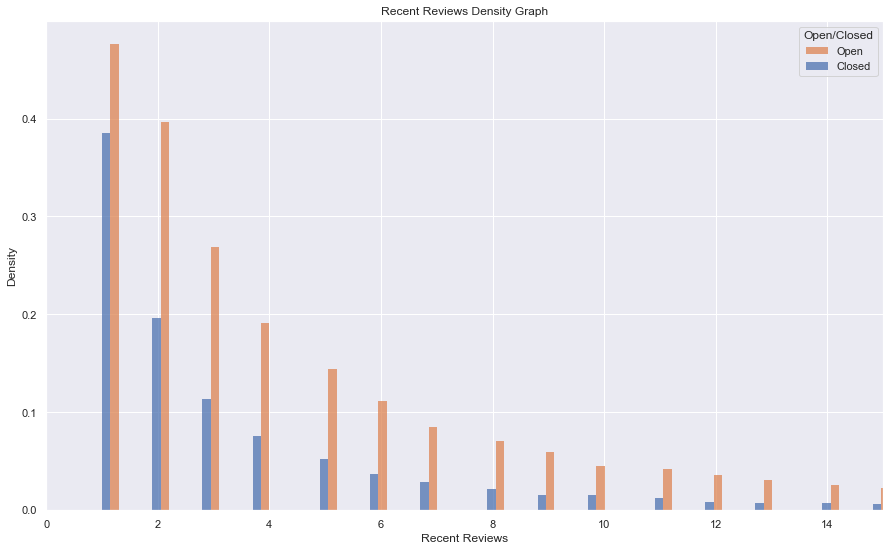

In [62]:
ax7 = sns.histplot(data=recent_reviews, x="recent_reviews", hue="is_open", multiple="dodge", stat="density")

ax7.set_xlim([0,15])
ax7.set(xlabel="Recent Reviews", ylabel="Density", title="Recent Reviews Density Graph")
plt.legend(title='Open/Closed', loc='upper right', labels=['Open', 'Closed'])

Once again, the distribution looks similar, but the open restaurant has longer right tail as expected. In addition, we can observe a consistent decrease in the number of recent reviews for the open restaurants, whereas a sudden decrease for the closed restaurants.

***
## User Check-In 

According to Yelp, check-ins are "a way to keep track of the local businesses you visit and keep your friends updated with your latest comings and goings. Each time you check-in you will have the option to share your check-in—with your Yelp friends or on Twitter —or keep it private. If you choose to share a check-in on a Social Media site, the audience that can see the check-in will depend on your privacy settings for that platform."

We can definitely leverage this data since more check-ins for a restaurant means more customers have visited, and possibly advertised through social media to attract even more people.

In [63]:
check_in = pd.read_json("data\yelp_academic_dataset_checkin.json", lines=True)
check_in.head(5)

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


We can see that check-ins for a business is clumped up in the *date* column, where each check-in date is separated by a comma. We will calculate the total number of check-ins per business, and merge it with our working dataset.

In [64]:
check_in["check_in_counts"] = check_in["date"].str.count(",") + 1 # Adds one because Python
check_in.head(5)

,business_id,date,check_in_counts
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020...",11
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011...",10
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22",2
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012...",10
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014...",26


In [65]:
final_data = pd.merge(recent_reviews, check_in, on="business_id", how="left") # Merges with the business & review data

final_data.fillna(value=0, inplace=True)
non_features = ["name", "categories", "date"] # Features that we do not need for the model
final_data.drop(columns=non_features, inplace=True)
final_data.head(5)

,business_id,stars_business,review_count,is_open,is_chain,relative_review,polarity_score,yelp_age,recent_reviews,check_in_counts
0,---kPU91CF4Lq2-WlRu9Lw,4.5,24,1,0,-0.252754,0.851179,1.975342,7,11.0
1,--0iUa4sNDFiZFrAdIWhZQ,3.0,14,1,0,-0.462739,0.544421,12.194521,1,10.0
2,--8IbOsAAxjKRoYsBFL-PA,3.0,27,0,1,-0.300230,0.261070,3.704110,1,32.0
3,--ARBQr1WMsTWiwOKOj-FQ,4.5,23,0,0,-0.355721,0.920148,3.164384,5,34.0
4,--MbOh2O1pATkXa7xbU6LA,4.0,25,0,0,-0.472317,0.844852,4.583562,6,103.0


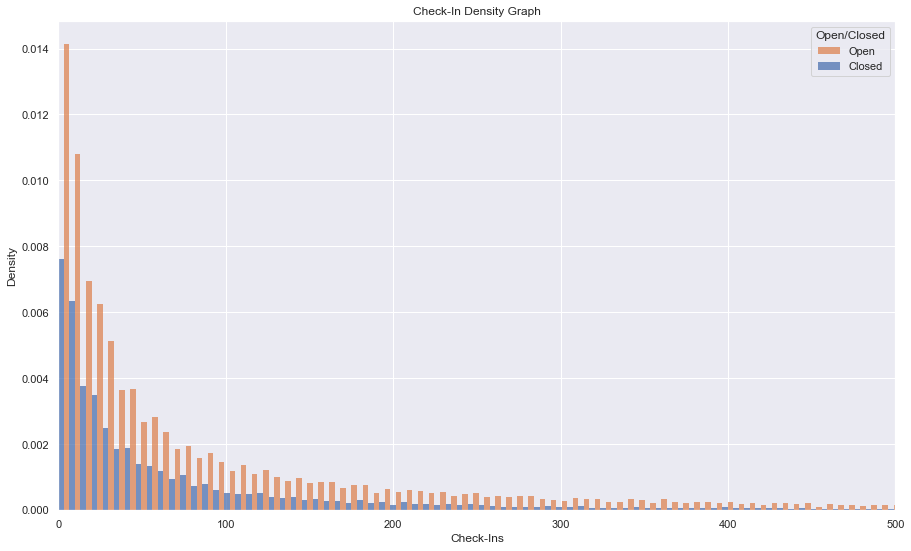

In [66]:
# Plots the check-in density graph
ax8 = sns.histplot(data=final_data, x="check_in_counts", hue="is_open", multiple="dodge", stat="density")

ax8.set_xlim([0,500])
ax8.set(xlabel="Check-Ins", ylabel="Density", title="Check-In Density Graph")
plt.legend(title='Open/Closed', loc='upper right', labels=['Open', 'Closed'])

Again, the distribution looks similar, but we can see open restaurants have longer right tail compared to the closed ones. We will finish up this section by normalizing some of the features and save the data for our model.

In [67]:
# Normalize some of our features
norm_columns = ["review_count", "yelp_age", "recent_reviews", "check_in_counts"]

scaler = MinMaxScaler() # Could also use StandardScaler()

for column in norm_columns:
    value = final_data[column].values
    reshaped = value.reshape(-1,1)
    normalized = scaler.fit_transform(reshaped)
    final_data[column] = normalized

final_data.head(5)

,business_id,stars_business,review_count,is_open,is_chain,relative_review,polarity_score,yelp_age,recent_reviews,check_in_counts
0,---kPU91CF4Lq2-WlRu9Lw,4.5,0.002512,1,0,-0.252754,0.851179,0.116569,0.006757,0.000274
1,--0iUa4sNDFiZFrAdIWhZQ,3.0,0.001190,1,0,-0.462739,0.544421,0.721304,0.000000,0.000249
2,--8IbOsAAxjKRoYsBFL-PA,3.0,0.002909,0,1,-0.300230,0.261070,0.218872,0.000000,0.000798
3,--ARBQr1WMsTWiwOKOj-FQ,4.5,0.002380,0,0,-0.355721,0.920148,0.186933,0.004505,0.000848
4,--MbOh2O1pATkXa7xbU6LA,4.0,0.002644,0,0,-0.472317,0.844852,0.270914,0.005631,0.002568


In [68]:
# Make sure that we did not lose any data in process
final_data.shape[0], business.shape[0]

(63757, 63757)

In [69]:
final_data.to_pickle("data\yelp_final_data.pkl")